## Data Preparation 

The following notebook prepares and cleans the housing listings data provided by idealista for the analysis of spatial inequalities of air conditioning. The analysis is for the paper titled 'Using Hedonic Modelling to Assess Spatial Inequalities of Air Conditioning in Madrid'. Key steps in this notebook include data cleaning, and the spatial join with neighbourhood level census variables to create the dataframe for the hedonic analysis in notebook 3.

The data for the study is not openly available and is provided by idealista as part of a PhD collaboration, thus one year of data that has been publically publised by idealista can be replaced with our data if you would like to replicate the analysis. The results will therefore not be the same.

In [41]:
# Read in libraries 
import pandas as pd
import geopandas as gpd
from shapely import wkt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [12]:
# Read in the data 
orig = pd.read_csv('Madrid_data_clean.csv')
orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882575 entries, 0 to 882574
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     882575 non-null  int64  
 1   ASSETID                        882575 non-null  object 
 2   PERIOD                         882575 non-null  int64  
 3   PRICE                          882575 non-null  float64
 4   UNITPRICE                      882575 non-null  float64
 5   CONSTRUCTEDAREA                882575 non-null  int64  
 6   ROOMNUMBER                     882575 non-null  int64  
 7   BATHNUMBER                     882575 non-null  int64  
 8   HASTERRACE                     882575 non-null  int64  
 9   HASLIFT                        882575 non-null  int64  
 10  HASAIRCONDITIONING             882575 non-null  int64  
 11  AMENITYID                      882575 non-null  int64  
 12  HASPARKINGSPACE               

### Remove repeated entries 

A caveat of housing listings data is the occurance of repeated entries when a property is posted more than once on the site, for example if the price changes, it doesn't sell in one quarter or to increase publicity. ASSET ID is a unique identifier of a property on idealista, thus any repeated IDs represent the same property repeated on the site. We order the listings by the date and ID and keep the final listing posted on the site as this is most representative of the final sale price. We remove 289,446 repeated property listings. 

In [16]:
# Step 1: Sort by ASSETID and PERIOD, and keep the last occurrence of each ASSETID
mad_data = orig.sort_values(by=['ASSETID', 'PERIOD'])  # Sort by ASSETID and PERIOD
mad_data = orig.drop_duplicates(subset='ASSETID', keep='last')
mad_data.info() # Check the number of entries

<class 'pandas.core.frame.DataFrame'>
Index: 593129 entries, 20 to 882574
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     593129 non-null  int64  
 1   ASSETID                        593129 non-null  object 
 2   PERIOD                         593129 non-null  int64  
 3   PRICE                          593129 non-null  float64
 4   UNITPRICE                      593129 non-null  float64
 5   CONSTRUCTEDAREA                593129 non-null  int64  
 6   ROOMNUMBER                     593129 non-null  int64  
 7   BATHNUMBER                     593129 non-null  int64  
 8   HASTERRACE                     593129 non-null  int64  
 9   HASLIFT                        593129 non-null  int64  
 10  HASAIRCONDITIONING             593129 non-null  int64  
 11  AMENITYID                      593129 non-null  int64  
 12  HASPARKINGSPACE                593

### Remove incorrect data 

We next remove any instances where the price is €0 and the floor number is 999 as these are mistakes in the data. There are 125 listings where the price is listed as €0 and one entry of Floor Number 999.

In [19]:
# Step 2: Remove rows where PRICE == 0
mad_data2 = mad_data[mad_data['PRICE'] != 0]
# Step 3: Remove rows where FLOOR NUMBER == 999
mad_data2 = mad_data2[mad_data2['FLOORCLEAN'] != 999]

### Read in Polygon Level Data and join to housing listings data 

For the hedonic models we also require data at the neighbourhood level which is calculated in the first notebook using data from various official census sources. This sections reads in this data and joins it to the housing listings data using a spatial join. 70 listings are dropped where the location of the property is outside of the neighbourhood boundaries.

In [24]:
# Read in neighbourhood level data 
# Replace with your file path ""
barrios_vars = pd.read_csv("neighbourhood_level_variables.csv") # At the neighbourhood level
district_vars = pd.read_csv("districts_final.csv")  # At the district level

In [26]:
# Make geometry valid and convert to geodataframe (barrios)
barrios_vars['geometry_x'] = barrios_vars['geometry_x'].apply(wkt.loads)
barrios_vars = gpd.GeoDataFrame(barrios_vars, geometry=barrios_vars['geometry_x'], crs=25830)

In [27]:
# Example: Select only columns needed for the analysis 
subset_bar = barrios_vars[['CODBAR', 'NOMBRE_x', 'income_2019','%_spanish_2021', 'pop_2021', '%_singlehouse_2021','avg_house_size_2021',  
                 'geometry', '%_u18_2021', '%_over65_2021', 'Average_age_2021', 'area_x', 'building_density', 'bench_density']]

In [31]:
# Convert to geodataframe (districts)
district_vars = gpd.GeoDataFrame(district_vars, geometry=district_vars['geometry'], crs=25830)

In [32]:
subset_dis = district_vars[['green_area_percent', 'tree_density', 'geometry', 'code_dis', 'name_dis']]

In [33]:
# Convert the housing listings data to a geodataframe with the correct crs 
gdf = gpd.GeoDataFrame(
    mad_data2, geometry=gpd.points_from_xy(mad_data2.LONGITUDE, mad_data2.LATITUDE), crs="EPSG:4326"
)

gdf2 = gdf.to_crs('25830')

In [45]:
# Perform the first spatial join to neighbourhood variables
points_with_polygons = gpd.sjoin(gdf2, subset_bar, how="inner", predicate="within")

# Drop the 'index_right' column
points_with_polygons = points_with_polygons.drop(columns=['index_right'])

# Perform the second spatial join (points_with_polygons within another set of polygons)
points_with_polygons2 = gpd.sjoin(points_with_polygons, subset_dis, how="inner", predicate="within")


In [35]:
# Inspect to check the join worked and there are no missing values. 
points_with_polygons2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 592933 entries, 20 to 882405
Data columns (total 55 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   Unnamed: 0                     592933 non-null  int64   
 1   ASSETID                        592933 non-null  object  
 2   PERIOD                         592933 non-null  int64   
 3   PRICE                          592933 non-null  float64 
 4   UNITPRICE                      592933 non-null  float64 
 5   CONSTRUCTEDAREA                592933 non-null  int64   
 6   ROOMNUMBER                     592933 non-null  int64   
 7   BATHNUMBER                     592933 non-null  int64   
 8   HASTERRACE                     592933 non-null  int64   
 9   HASLIFT                        592933 non-null  int64   
 10  HASAIRCONDITIONING             592933 non-null  int64   
 11  AMENITYID                      592933 non-null  int64   
 12  HASPARKINGSP

### Join to satellite image feature clusters

In [73]:
# Read in labels
labels = pd.read_csv('labels_geometry.csv')

In [74]:
# Create a GeoDataFrame
# Make geometry valid and convert to geodataframe 
labels['geometry'] = labels['geometry'].apply(wkt.loads)
labels = gpd.GeoDataFrame(labels, geometry=labels['geometry'], crs=25830)

In [77]:
# Perform the spatial join to satellite image clusters
# Drop the 'index_right' column
points_with_polygons2 = points_with_polygons2.drop(columns=['index_right'])
points_with_polygons3 = gpd.sjoin(points_with_polygons2 , labels, how="inner", predicate="within")

In [79]:
points_with_polygons3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 592923 entries, 20 to 556954
Data columns (total 57 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   Unnamed: 0_left                592923 non-null  int64   
 1   ASSETID                        592923 non-null  object  
 2   PERIOD                         592923 non-null  int64   
 3   PRICE                          592923 non-null  float64 
 4   UNITPRICE                      592923 non-null  float64 
 5   CONSTRUCTEDAREA                592923 non-null  int64   
 6   ROOMNUMBER                     592923 non-null  int64   
 7   BATHNUMBER                     592923 non-null  int64   
 8   HASTERRACE                     592923 non-null  int64   
 9   HASLIFT                        592923 non-null  int64   
 10  HASAIRCONDITIONING             592923 non-null  int64   
 11  AMENITYID                      592923 non-null  int64   
 12  HASPARKINGSP

### Remove outliers in the unit price

For the hedonic model it is necassary to reduce the skew of the data, housing prices are skewed to the right with a few expensive outliers. The next section removes outliers based on the upper bound of the interquartile range. We remove 14,729 listings which are over €7,091 per square meter.

In [81]:
# Set pandas to display floats in a standard decimal format
pd.set_option('display.float_format', '{:.6f}'.format)

# Get summary statistics for unit price
points_with_polygons3.UNITPRICE.describe()

count    592923.000000
mean       3208.424288
std        5827.677425
min           0.974937
25%        1921.875000
50%        2843.478000
75%        3989.949749
max     1528933.000000
Name: UNITPRICE, dtype: float64

In [82]:
# Calculate the interquartile range
Q1 = 1921
Q3 = 3989
IQR = Q3 - Q1

# Calculate bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where UNITPRICE exceeds the upper bound
gdf_hp = points_with_polygons3[points_with_polygons3['UNITPRICE'] <= upper_bound]


In [83]:
upper_bound

7091.0

In [49]:
gdf_hp.UNITPRICE.describe()

count   578204.000000
mean      2990.562349
std       1379.867732
min          0.974937
25%       1900.000000
50%       2795.698925
75%       3888.889000
max       7090.909091
Name: UNITPRICE, dtype: float64

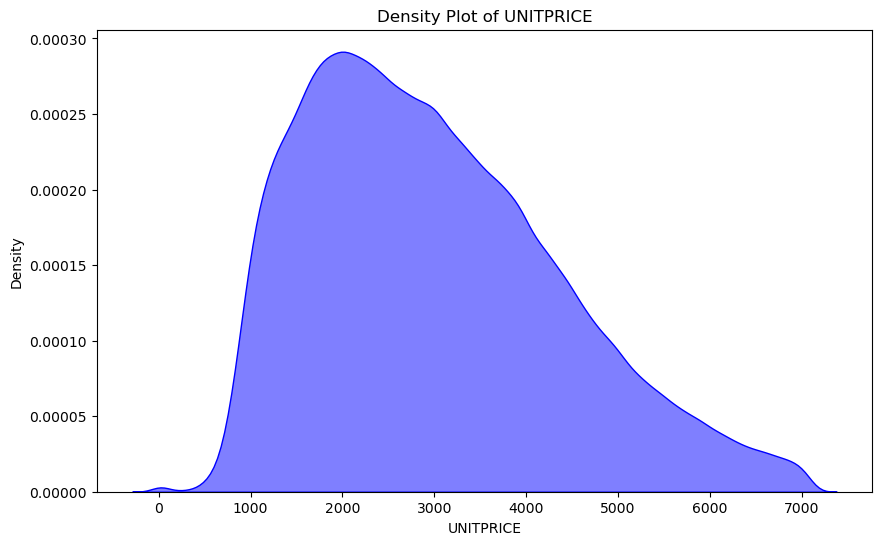

In [91]:
# Visualization of the distribution of UNITPRICE
plt.figure(figsize=(10,6))
sns.kdeplot(gdf_hp['UNITPRICE'], fill=True, color="blue", alpha=0.5)
plt.title("Density Plot of UNITPRICE")
plt.xlabel("UNITPRICE")
plt.ylabel("Density")
plt.show()


### Check for any more outliers

Then we examine the other variables to check for any outliers. The variable ROOMNUMBER, which represents the number of bedrooms is heavily skewed to the right. We remove 114 listings with over 15 bedrooms as these represent entire buildings for sale and for the analysis we need properties at the individual level.

In [54]:
# Get summary statistics for all variables
gdf_hp.describe()

,Unnamed: 0,PERIOD,PRICE,UNITPRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,...,%_u18_2021,%_over65_2021,Average_age_2021,area_x,building_density,bench_density,index_right,green_area_percent,tree_density,code_dis
count,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,...,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000,578204.000000
mean,57465.474860,201561.337452,329955.076409,2990.562349,106.293454,2.655258,1.583457,0.323848,0.695531,0.365352,...,14.358716,20.792316,44.338151,3060852.290317,0.000794,0.000348,8.298822,9.634004,0.002503,9.298822
std,35283.683450,247.899800,365718.309069,1379.867732,888.041835,1.260689,0.883334,0.467943,0.460182,0.481529,...,4.068305,5.432514,3.002387,6819776.886096,0.000529,0.000163,5.695278,5.317018,0.001000,5.695278
min,0.000000,201003.000000,1000.000000,0.974937,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.871429,2.300000,31.900000,249064.270000,0.000002,0.000002,0.000000,1.548261,0.000244,1.000000
25%,29644.000000,201312.000000,134000.000000,1900.000000,64.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,12.227778,17.100000,42.900000,853192.220000,0.000392,0.000243,3.000000,6.020553,0.002066,4.000000
50%,54812.000000,201606.000000,223000.000000,2795.698925,84.000000,3.000000,1.000000,0.000000,1.000000,0.000000,...,13.400000,21.960000,45.033333,1306150.890000,0.000753,0.000346,8.000000,7.851998,0.002730,9.000000
75%,80736.000000,201806.000000,391000.000000,3888.889000,117.000000,3.000000,2.000000,1.000000,1.000000,1.000000,...,15.884615,24.450000,46.402941,2278006.820000,0.000987,0.000451,13.000000,11.851522,0.002991,14.000000
max,158439.000000,201912.000000,50459000.000000,7090.909091,399000.000000,150.000000,99.000000,1.000000,1.000000,1.000000,...,32.537500,35.642308,50.011538,187713864.500000,0.002531,0.000906,20.000000,21.580299,0.003990,21.000000


In [84]:
# Drop rows where ROOMNUMBER is greater than 15
gdf_hp2 = gdf_hp[gdf_hp['ROOMNUMBER'] <= 15]

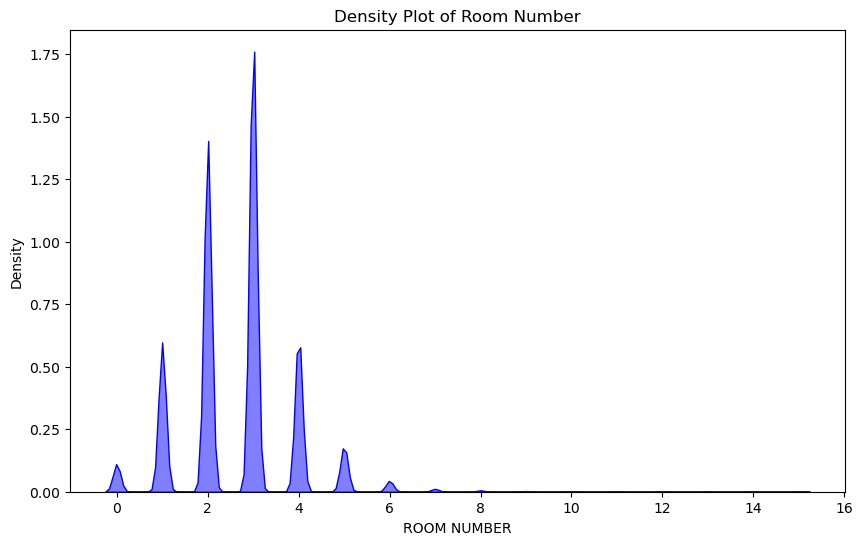

In [62]:
plt.figure(figsize=(10,6))
sns.kdeplot(gdf_hp2['ROOMNUMBER'], fill=True, color="blue", alpha=0.5)
plt.title("Density Plot of Room Number")
plt.xlabel("ROOM NUMBER")
plt.ylabel("Density")
plt.show()

### Calculate new variables 
Finally we create new variables needed for the analysis, including population density, cooling demand category and the log of unit price. 

In [85]:
# Calculate Population Density using the population count and size of the neighbourhoods
gdf_hp2['pop_den'] = gdf_hp2['pop_2021'] / gdf_hp2['area_x']


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [86]:
# Concert the year of construction to cooling demand category 
# Define the bins and numeric labels 
bins = [0, 1940, 1980, 2006, float('inf')]  # Define the year ranges
labels = [1, 3, 2, 1]                      # 1: Lowest, 3: Highest, 2: Moderate

# Create a new column with the classification
gdf_hp2['CoolingDemandCategory'] = pd.cut(gdf_hp2['CADCONSTRUCTIONYEAR'], bins=bins, labels=labels, right=False, ordered=False)



/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [87]:
# Log-transform the outcome varible column
gdf_hp2['Log_UNITPRICE'] = np.log(gdf_hp2['UNITPRICE'])

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# Log-transform the outcome varible column
gdf_hp2['Log_UNITPRICE'] = np.log(gdf_hp2['UNITPRICE'])

In [88]:
# Save DataFrame as CSV
gdf_hp2.to_csv('cleaned_data_hp_aircon.csv', index=False)